# Business Understanding

This notebook is using a dataset from AirBnb activities in Seattle. AirBnb is a company that give people the opportunity to rent an accommodation. Therefore it is interesting to see what is a good price.

In this notebook I'm going to answer the following questions:

    1. What is the price proportion in Seattle?
    2. Are there features that influences the price?
    3. Which features influence the price at most?

# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


# Data Understanding

In this part I'm going to load the data into the notebook and get familiar with the data by checking my dataframe. What is the size of the dataframe and which features contains the dataframe. What columns need to be migrated?

In [2]:
df = pd.read_csv('./seattle/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
print('Seattle listings dataset has a shape of ', df.shape)

Seattle listings dataset has a shape of  (3818, 92)


### Clean data set

Search for missing values and drop columns that have only missing values. The df.info() shows, there is one columns called "licence" that can be savely removed due to no data. It also shows that there are no rows with only null values, so lets remove some not needed columns first.

In [4]:
df.dropna(axis=1, how='all', inplace=True)
print('Seattle listings dataset has a shape of ', df.shape)

Seattle listings dataset has a shape of  (3818, 91)


Next searching for columns with unique values as they can be savely removed as well. Because I'm looking at the Seattle airbnb data only, I can remove columns like country, country_code and so on. If I would like to compare this dataset to another dataset from airbnb (for instance Berlin or Boston or what ever) I would not remove all of these rows.

In [5]:
print('Columns to remove that have only unique values:')
cols_unique = []
for col in df.columns:
    if df[col].value_counts().size == 1:
        cols_unique.append(col)
        print(col)
df.drop(columns=cols_unique, inplace=True)
print('\nSeattle listings dataset has a shape of ', df.shape)

Columns to remove that have only unique values:
scrape_id
last_scraped
experiences_offered
market
country_code
country
has_availability
calendar_last_scraped
requires_license
jurisdiction_names

Seattle listings dataset has a shape of  (3818, 81)


### Modifying data

There are columns that have the wrong data type. All columns that contains price information needs to be converted into columns of type float. 

In [6]:
cols_with_prices = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
df[cols_with_prices].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$85.00,NaN,NaN,NaN,NaN,$5.00
1,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00
3,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00
4,$450.00,NaN,NaN,$700.00,$125.00,$15.00


In [7]:
for col in cols_with_prices:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
    
df[cols_with_prices].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,NaN,NaN,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,NaN,NaN,1000.0,300.0,25.0
3,100.0,650.0,2300.0,NaN,NaN,0.0
4,450.0,NaN,NaN,700.0,125.0,15.0


Also there are 2 column called "\_rate" that should be converted into numeric columns.

In [8]:
cols_with_rates = ['host_response_rate', 'host_acceptance_rate']
df[cols_with_rates].head()

,host_response_rate,host_acceptance_rate
0,96%,100%
1,98%,100%
2,67%,100%
3,NaN,NaN
4,100%,NaN


In [9]:
for col in cols_with_rates:
    df[col] = df[col].replace({'\%': ''}, regex=True).astype(float)
    
df[cols_with_rates].head()

,host_response_rate,host_acceptance_rate
0,96.0,100.0
1,98.0,100.0
2,67.0,100.0
3,NaN,NaN
4,100.0,NaN


Now we are able to plot a histogram that show the proportion of the price over the dataset.

### Questions: What is the price proportion in Seattle?

With the first question I'm looking at the common price for one night in Seattle. This price gives me a feeling of what offers are common, cheap or quite expensive.

<AxesSubplot:>

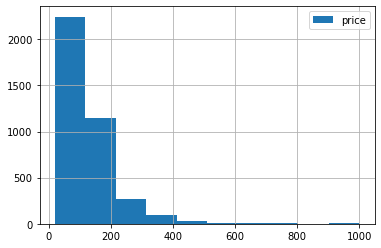

In [10]:
df['price'].hist(legend=True)

As we can see most prices are between nearly nothing and 200 dollar.

<AxesSubplot:>

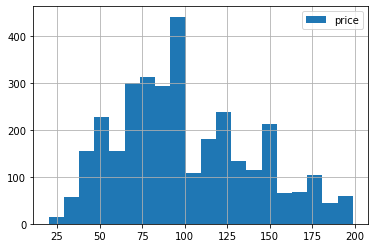

In [11]:
price_lower_150 = df[df['price'] < 200]
price_lower_150['price'].hist(bins=20, legend=True)

When we look in that range in more detail we get a peak at around 100 dollar.

### Answer: What is the price proportion in Seattle?

As we can see in the plots above the average price per night in Seattle is something between 50 and 100 dollar, where 100 dollar is a quite common price. 


### Question 2: Are there features that influences the price?

In question 1 we have seen that 100 dollar is a quite common price for one night in Seattle. In question 2 I'm looking at some features to get a clearer view of the composition of a price. 

In [12]:
def plot_mean_price_for_feature(feature, sortBy, asc=False):
    '''
    INPUT
    feature - a name of a feature (name of a column from the dataset)
    sortBy - name of the column of the inner dataset to sort on, it could be the feature, 'mean_price' or 'count'
    asc - True or False if sorting is ascending (default=False)
    
    OUTPUT
    Plots diagrams for mean_price and count for the given feature.
    '''
    feature_df = pd.DataFrame(columns=[feature, 'mean_price', 'count'])
    for value in df[feature].value_counts().keys():
        feature_df = feature_df.append({feature: value, 
                             'mean_price': df[df[feature]==value]['price'].mean(),
                             'count': df[df[feature]==value]['price'].count()
                            }, ignore_index=True)
    feature_df = feature_df.sort_values(by=[sortBy], ascending=asc)
    feature_df.plot(x=feature, kind='bar', legend=False, subplots=True);
    plt.show()
        

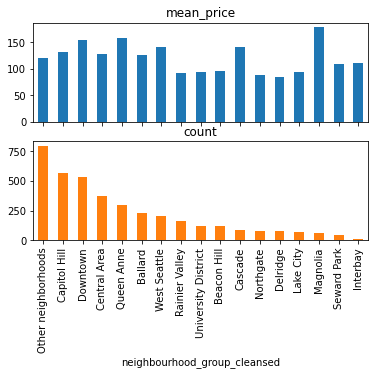

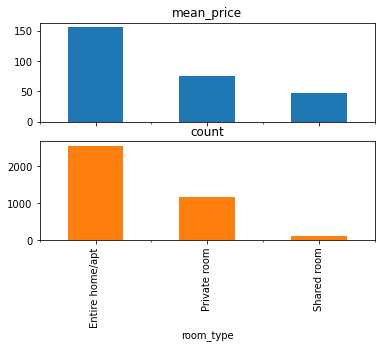

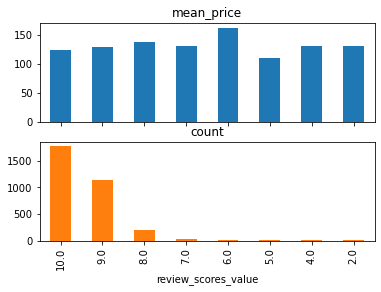

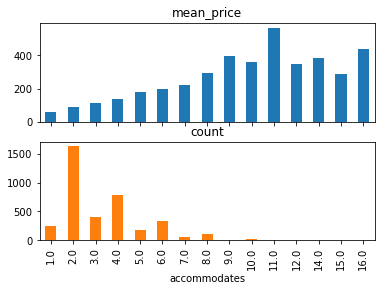

In [13]:
plot_mean_price_for_feature('neighbourhood_group_cleansed', 'count')
plot_mean_price_for_feature('room_type', 'count' )
plot_mean_price_for_feature('review_scores_value', 'review_scores_value')
plot_mean_price_for_feature('accommodates', 'accommodates', True)


### Answer: Are there features that influences the price?

From the above plots we can see, that the neighbourhood influences the price. Most of the accommodations are in Downtown, Capital Hill or Central Area, which means very central. In Downtown is the price much higher than in Capital Hill or Central Area. 

Looking at the features number of accommodates or room_type there is not really any surprise, both have an effect on the price in a usual way. The more accommodate the higher the price or an entire flat/appartment is more expensive than a private room.

The review scores seems to have no influence on the price. The most scores are between 9 to 10. There is no relation between score and mean price.

### Question 3: Which features influence the price at most?

In question 2 we have learned there are features that influences the price and others that seems to have no influence on the price at all. 

In question 3 I want to know, which features influence the price at most. In order to answer this question I'll use a machine learning technique called regression. After preparing my dataset I will split it into train and test data. Then I will train a model using the training data and test my model on the test data set. If I find a model that works I can look at the coefficents that have an impact on the price. The larger the coefficent the larger the influence on the price. Can I confirm my answer from question 2?

# Prepare data

In order to train a linear regression model I need a dataset with non null values. Remember I've already removed some features, which where useless to train a model. It was one columns with no value and 10 columns with only one unique value. I also migrated all the price or rate columns from object to float by removing the $ or \% sign. Now I'm going to look at the other columns or features.

First lets have a look at the categorical features. There are some more features that can be removed.

In [14]:
def get_columns(df, dtype):
    '''
    INPUT
    df - dataframe
    dtype - name of the data type
    
    OUTPUT
    Column names in the given dataframe with given dtype
    '''
    return df.select_dtypes(include=[dtype]).columns

In [15]:
def show_value_proportion(df, dtype):
    '''
    INPUT
    df - dataframe
    dtype - name of the data type
    
    OUTPUT
    DataFrame showing names, number of notna, number of unique values and there percentage
    
    Create a dataframe which contains the name of the feature, the total number of values 
    for that feature, the number of unique values for that feature and a value how many values are unique. 
    '''
    df_value = pd.DataFrame(columns=['name', 'notna values', 'unique values', 'percent unique values'])
    for cat_feature in get_columns(df, dtype):
        notna_values = df[cat_feature].notna().sum()
        unique_values = df[cat_feature].value_counts().size
        df_value = df_value.append({'name': cat_feature,
                                               'notna values': notna_values,
                                               'unique values': unique_values,
                                               'percent unique values': unique_values/notna_values},
                                              ignore_index=True)

    df_value = df_value.sort_values(by=['percent unique values'], ascending=False)
    return df_value


In [16]:
show_value_proportion(df, 'object')

,name,notna values,unique values,percent unique values
0,listing_url,3818,3818,1.000000
8,thumbnail_url,3498,3498,1.000000
10,picture_url,3818,3818,1.000000
9,medium_url,3498,3498,1.000000
11,xl_picture_url,3498,3498,1.000000
1,name,3818,3792,0.993190
4,description,3818,3742,0.980094
3,space,3249,3119,0.959988
2,summary,3641,3478,0.955232
6,notes,2212,1999,0.903707


From the table above we can see a lot of features that have a more than 50 unique values in a column. What does that mean and can I remove these columns? 

There are 5 "\_url" columns that contains only unique values and also there are 3 more "host\_somethin\_url" features.  Most of the features contains names, descriptions, somekind of complex information, which must be more analysed in order to collect data to train a model.

There is one special column, that I prefer to handle in a special way. In column "host_verifications" is a list of possible ways a host can verify something. 

This needs 3 steps:

In [17]:
df['host_verifications'].head()

0                 ['email', 'phone', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'linkedin', 're...
2     ['email', 'phone', 'google', 'reviews', 'jumio']
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4     ['email', 'phone', 'facebook', 'reviews', 'kba']
Name: host_verifications, dtype: object

Step 1: replace some characters

In [18]:
df['host_verifications'] = df['host_verifications'].replace({'\[':'', '\]': '', '\'': '', ' ': ''}, regex=True).astype(str)
df['host_verifications'].head()

0                        email,phone,reviews,kba
1    email,phone,facebook,linkedin,reviews,jumio
2               email,phone,google,reviews,jumio
3             email,phone,facebook,reviews,jumio
4               email,phone,facebook,reviews,kba
Name: host_verifications, dtype: object

Step 2: create a dummy dataframe for the Series with prefix

In [19]:
df_host_verifications = df['host_verifications'].str.get_dummies(sep=',').add_prefix('host_verification_')
print("Shape of df_host_verifications", df_host_verifications.shape)
df_host_verifications.head()

Shape of df_host_verifications (3818, 15)


,host_verification_None,host_verification_amex,host_verification_email,host_verification_facebook,host_verification_google,host_verification_jumio,host_verification_kba,host_verification_linkedin,host_verification_manual_offline,host_verification_manual_online,host_verification_phone,host_verification_photographer,host_verification_reviews,host_verification_sent_id,host_verification_weibo
0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0
2,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0
3,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0
4,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0


Step 3: Concat the 2 DataFrames 

Doing this adds 15 new columns to the dataset. If I had handled this column with get_dummies() there would be 116 columns instead.

In [20]:
df = pd.concat([df, df_host_verifications], axis=1)

I decided to remove all columns that have more than 50 unique values, because there is not much information to find any connection in the dataset.

In [21]:
categorical_df = show_value_proportion(df, 'object')
drop_too_unique_columns = categorical_df[categorical_df['unique values'] > 50]['name']
df.drop(columns=drop_too_unique_columns, inplace=True)

All other categorical features will be prepared for the dataset by introducing dummy variables for them.


In [22]:
df = pd.get_dummies(df, drop_first=True)

Now lets have a look at the numeric features. There is one column called "square_feet", that has only 2.5% of data. I decided also to drop this column, because filling 97.5% of a column with calculated data does not feel very comfortable. 

Also Column "host_acceptance_rate" has just one value 0 and more than 3000 values are 100. Filling missing data with the mean, which is 99.9 there are just values around 100 except one value. I will also drop that column.

As "host_listings_count" and "host_total_listings_count" are equal one of them can be removed.

Because I want to predict the price I don't need the weekly_price or the monthly_price. 

In [23]:
df['square_feet'].describe()

count      97.000000
mean      854.618557
std       671.404893
min         0.000000
25%       420.000000
50%       750.000000
75%      1200.000000
max      3000.000000
Name: square_feet, dtype: float64

In [24]:
df['host_acceptance_rate'].value_counts()

100.0    3044
0.0         1
Name: host_acceptance_rate, dtype: int64

In [25]:
df[['host_listings_count', 'host_total_listings_count']].describe()

,host_listings_count,host_total_listings_count
count,3816.000000,3816.000000
mean,7.157757,7.157757
std,28.628149,28.628149
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,502.000000,502.000000


In [26]:
numeric_columns_to_drop = ['square_feet', 'host_acceptance_rate', 'host_total_listings_count', 'weekly_price', 'monthly_price']
df.drop(columns=numeric_columns_to_drop, inplace=True)

In [27]:
df.isna().sum().sum()

8735

Last step in my preparation of the dataset is to fill the NaNs with the mean. 

In [28]:
df.fillna(value=df.mean(), inplace=True)
df.isna().sum().sum()

0

# Data Modeling

#### Find the influencer

With a well prepared dataset I can search for the features that influences the price at most. Here is my idea. Since this whole dataset is small enough I can train a model for each feature and see the impact of that feature directly. The higher the r2 score for a feature the more impact has the feature on my predicted feature.

In [29]:
def find_influencing_features(df, col_predict):
    '''
    INPUT:
    df - DataFrame 
    col_pred - name of the column, that will be predicted
    
    OUTPUT:
    DataFrame that shows the impact of a feature in the dataframe on the predicted column using the r2_score
    '''
    columns = df.drop(columns=[col_predict], axis=1).columns
    y = df[col_predict]
    
    df_impact = pd.DataFrame()
    
    for col in columns:
        X = df[[col]]
        
        #Split into train and test dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42) 

        # Instantiate the model with normalization
        lm_model = LinearRegression(normalize=True)

        # Fit the model with the train dataset
        lm_model.fit(X_train, y_train)

        #Predict and score the model
        y_train_preds = lm_model.predict(X_train) 
        y_test_preds = lm_model.predict(X_test) 
        
        df_impact = df_impact.append({
            'feature': col,
            'r2_train': r2_score(y_train, y_train_preds),
            'r2_test': r2_score(y_test, y_test_preds)
        }, ignore_index=True)
        
    df_impact = df_impact.sort_values(by=['r2_test'], ascending=False)
    return df_impact
    

In [30]:
df_influencer = find_influencing_features(df, 'price')

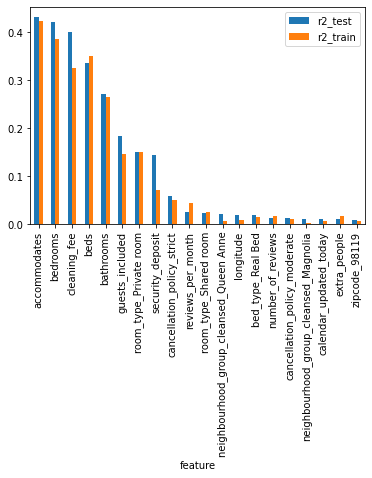

In [31]:
df_influencer.head(20).plot(x='feature', kind='bar', legend=True);

### Answer: Which features influence the price at most?

The plot above shows that the number of accommodates, bedrooms, beds and bathrooms and also if there is a cleaning fee influences the price at most. Also an effect has the room type and the location of the accommodation, since all the neighbourhood, zipcodes or even the longitude are part of the bigger picture "location of the accommodation".

There are 66 feature that have a positive r2 score on the test data. Lets see how a combination of these features will work on a model and how many features contains the best model.

In [32]:
def find_optimal_lm_mod(df, y, influencers, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    df - pandas dataframe
    y - pandas dataframe, response variable
    influencers - sorted list of column names, the have the most impact 
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for number_of_influencer in range(influencers.size):

        #reduce X matrix
        reduce_X = df[influencers[:number_of_influencer+1].values]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[number_of_influencer] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by number of sorted influencers')
        plt.legend(loc=0)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = df[influencers[:best_cutoff+1].values]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

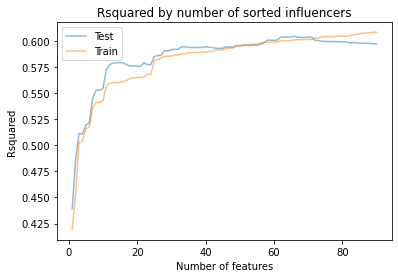

In [33]:
y = df['price']
influencers = df_influencer['feature'].head(90)
#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(df, y, influencers)

Check the number of features in the best model.

In [34]:
lm_model.n_features_in_

66

Get the r-squared score for the test dataset on the best model.

In [35]:
lm_model.score(X_test, y_test)

0.6042047840605336

# Evaluate the Results

The best model also contains 66 features, which are the features that have a positive r2 score. We can also see, that the first 15 most influencing properties build a r2 score of 0.579 for the test dataset. The best model with 66 features has only a slightly higher score with 0.604. That means improving the score by 0.025 points it needs 51 features more in the model. 

In [36]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
12,longitude,109.997274,109.997274
57,property_type_Dorm,-63.088020,63.088020
10,room_type_Shared room,-60.130698,60.130698
24,neighbourhood_group_cleansed_Downtown,29.717269,29.717269
25,neighbourhood_group_cleansed_Northgate,-28.544012,28.544012
16,neighbourhood_group_cleansed_Magnolia,28.506549,28.506549
6,room_type_Private room,-28.175360,28.175360
46,neighbourhood_group_cleansed_Lake City,-23.522964,23.522964
4,bathrooms,23.379167,23.379167
22,zipcode_98144,-22.818180,22.818180


Looking at the coefficients of the best model confirms the answers given above. Features belonging to the location of a accommodation, the room type and number of bathrooms and bedrooms have the most impact on the prediction of the price.